In [1]:
import rasterio
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from fiona import listlayers
import os
import json
from shapely import wkt
import pandas as pd
from shapely.geometry import Polygon
from rasterio.crs import CRS
import fiona
import periodictable as pt
import rasterio
from rasterio.mask import mask

In [2]:
# Path to your raster file
tif_path = "/Users/Administrator/Downloads/pH_H2O/pH_H2O.tif"

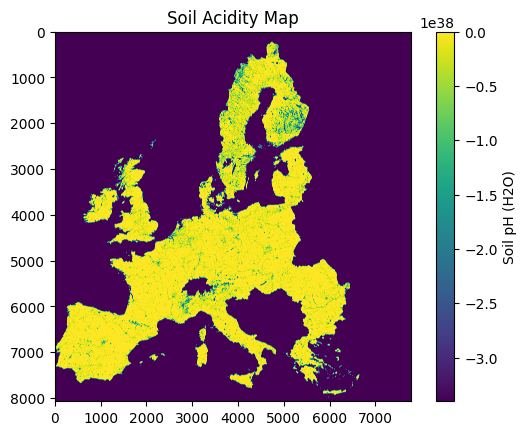

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 7781, 'height': 8073, 'count': 1, 'crs': CRS.from_wkt('PROJCS["ETRS89-extended / LAEA Europe",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4258"]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",52],PARAMETER["longitude_of_center",10],PARAMETER["false_easting",4321000],PARAMETER["false_northing",3210000],UNIT["metre",1],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","3035"]]'), 'transform': Affine(500.00000000000006, 0.0, 2635699.9999999995,
       0.0, -500.0, 5422200.0), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'interleave': 'band'}


In [3]:
# Open the raster
with rasterio.open(tif_path) as src:
    data = src.read(1)  # Read first band
    profile = src.profile

# Plot it
plt.imshow(data, cmap='viridis')
plt.colorbar(label='Soil pH (H2O)')
plt.title('Soil Acidity Map')
plt.show()

# Print metadata
print(profile)


In [4]:
def aoi_finder():
    # load Utrecht polygon coordinates
    utrecht_polygon_path = '/Users/Administrator/Documents/University/Year 3/2b/Thesis/Bachelor-Thesis/data/raw/utrecht polygon.csv'
    df = pd.read_csv(utrecht_polygon_path, sep=';')

    geo_shape_str = df.loc[0, "Geo Shape"] #coordinates of the polygon
    geo_shape = json.loads(geo_shape_str)
    coords = geo_shape["coordinates"][0]  # outer ring of the polygon

    utrecht_polygon = Polygon(coords)

    # define boundary line
    x1, y1 = 5.066884, 52.170366  # upper-left
    x2, y2 = 5.237030, 51.978896  # lower-right

    def is_above_line(x, y):
        """Returns True if point (x, y) is above the diagonal line"""
        if x1 == x2:
            return y > y1  # vertical line
        slope = (y2 - y1) / (x2 - x1)
        y_on_line = slope * (x - x1) + y1
        return (y > y_on_line) and (x > x1)

    # Filter polygon coordinates
    filtered_coords = [
        (x, y) for x, y in utrecht_polygon.exterior.coords
        if is_above_line(x, y)]

    # Make sure polygon closes properly
    if filtered_coords[0] != filtered_coords[-1]:
        filtered_coords.append(filtered_coords[0])

    #new precise polygon
    aoi = Polygon(filtered_coords)

    utrecht_mask = gpd.GeoDataFrame(geometry=[aoi], crs="EPSG:4326")
    return utrecht_mask

In [5]:
aoi_gdf = aoi_finder()

# Open raster and crop
with rasterio.open(tif_path) as src:
    aoi_gdf = aoi_gdf.to_crs(src.crs)  # Match CRS
    out_image, out_transform = mask(src, aoi_gdf.geometry, crop=True)
    out_meta = src.meta.copy()

# Update metadata
out_meta.update({
    "driver": "GTiff",
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform
})

# Save cropped raster (optional)
with rasterio.open("cropped_pH_CaCl.tif", "w", **out_meta) as dest:
    dest.write(out_image)

In [6]:
data = out_image[0]
data[data < 0] = np.nan

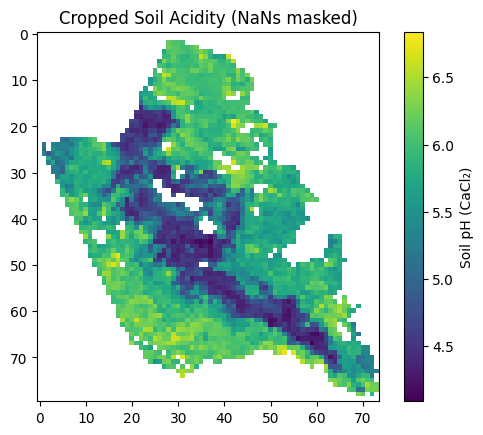

In [7]:
plt.imshow(data, cmap='viridis')
plt.colorbar(label="Soil pH (CaCl₂)")
plt.title("Cropped Soil Acidity (NaNs masked)")
plt.show()

## Update Nitrate dataset

In [8]:
nitrate_path = '/Users/Administrator/Documents/University/Year 3/2b/Thesis/Bachelor-Thesis/data/aligned/merged_dataset_1.csv'
nitrate_df = pd.read_csv(nitrate_path)

In [9]:
nitrate_df["geometry"] = nitrate_df["geometry"].apply(wkt.loads)
gdf = gpd.GeoDataFrame(nitrate_df, geometry="geometry", crs="EPSG:4326")

In [10]:
gdf = gdf.to_crs("EPSG:3035")

gdf['date'] = pd.to_datetime(gdf['date'], errors='coerce', utc=True)
gdf['year'] = gdf['date'].dt.year

# Filter for years 2008–2014
mask_years = gdf["year"].between(2008, 2013)
gdf_sub = gdf.loc[mask_years].copy()

In [11]:
with rasterio.open(tif_path) as src:
    nodata_val = src.nodata or -9999  # Fallback if nodata not set
    coords = [(geom.x, geom.y) for geom in gdf_sub.geometry]
    values = list(src.sample(coords))
    values = np.array([
    round(v[0], 2) if v[0] > 0 and v[0] != nodata_val else np.nan
    for v in values
    ])

# Assign to column
gdf_sub["acidity_1"] = values

# Merge back into full dataset
gdf.loc[mask_years, "acidity_1"] = gdf_sub["acidity_1"]

In [12]:
gdf = gdf.drop(columns="year").copy()

In [13]:
# If needed, save updated CSV
gdf.to_csv("merged_dataset_with_acidity.csv", index=False, float_format="%.2f")